In [40]:
!pip install prophet # optional, this is to play with fbprophet (https://facebook.github.io/prophet/docs/quick_start.html#python-api)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

from matplotlib import style
from datetime import datetime, timedelta

## Getting the data

Freely available structured data for the greek stock market indices are not easy to come by - especially nowadays with the excellent `investpy` library being [out of commission](https://github.com/alvarobartt/investpy/issues/600) at least for the foreseeable future.

Fortunately several greek finance online publications maintain tables of daily prices and OHLC data. In this instace we use a csv file published by capital.gr (link [link text](https://www.capital.gr/finance/historycloses/ftse?page=1)) which is updated a couple hours after market close time (~ 19:00 - 20:00 EET).

The data available cover the period from 01/01/1995 - today, however we are focusing on the the index evolution since 2017.



In [51]:
# get FTSE25 data from capital.gr (https://www.capital.gr/finance/historycloses/ftse?page=1)
data = pd.read_csv('https://www.capital.gr/finance/quotes/exporthistorycloses?symbol=ftse&key=1148639707', skiprows = 1, decimal=",")  

# remove columns we are not using
del data['ΜΕΤ.%']
del data['Τζίρος']

# convert date to date format
data['Ημ/νία'] = pd.to_datetime(data['Ημ/νία'], format="%d/%m/%Y")

# rename columns to en
data.columns = ['date', 'close', 'open', 'high', 'low', 'volume']

# make date index
data.set_index('date', inplace = True)

# convert volume column from string to float
data['volume'] = data['volume'].str.replace(".","").astype(float)

# rearrange columns
data = data[['open', 'high', 'low', 'close', 'volume']]

# keep data from 01/01/2017 and sort ascending
data = data[(data.index > "2017-01-01")].sort_index(ascending=True)

# check for missing values (this will be included in the QC section of the final pipeline for the daily ingested data along with the other quality checks)
data.isnull().sum()

# view a sample
print(data)

               open     high        low      close      volume
date                                                          
2017-01-02  1741.46  1753.04  1740.6700  1744.9400  18213258.0
2017-01-03  1750.98  1778.75  1745.8300  1769.6900  68663545.0
2017-01-04  1778.02  1780.06  1763.2400  1773.8400  52684044.0
2017-01-05  1773.71  1773.94  1752.6400  1773.9400  66179243.0
2017-01-09  1773.62  1773.81  1751.8300  1769.7400  31669813.0
...             ...      ...        ...        ...         ...
2022-09-23  1965.10  1974.28  1912.9301  1916.2500  21076374.0
2022-09-26  1908.19  1927.38  1881.0600  1904.2000  13750969.0
2022-09-27  1923.99  1939.19  1918.1100  1918.1100  18292863.0
2022-09-28  1902.70  1919.46  1876.4700  1899.5700  19235792.0
2022-09-29  1899.99  1913.71  1891.9700  1894.0699  13045188.0

[1424 rows x 5 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


## Data processing
We add columns for:


1.   daily absolute percentage change,
2.   standard deviation of return,
3.   weekly historical volatility.



In [50]:
# to delete
del data['pct_change']
del data['returns']
del data['volatility']
del data['returns2']

data

KeyError: ignored

In [60]:
#calculate daily absolute daily return, logarithmic return, and weekly historical volatility
data['abs_return'] = 100*data['close'].pct_change()
data['log_return'] = 100* (np.log(data['close'] / data['close'].shift(1)))
data['daily_vol'] = data['log_return'].std()
data['monthly_vol'] = data.apply(lambda x:x[['log_return']].std())
data['volatility'] = data['log_return'].rolling(window = 21).std()*np.sqrt(21)

In [23]:
data['returns2'] = 100* (np.log(data['close'] / data['close'].shift(1)))


data['returns'].fillna(0, inplace=True)
data['volatility'] = data['returns'].rolling(window = 21).std()*np.sqrt(21)

# get close price in new dataframe
#test = data['close'].sort_index(ascending=True).to_frame()

#calculate percent change
#test['pct_change'] = 100*test['close'].pct_change()



# convert vol time series to data frame
#vol = volatility.to_frame()

4.58257569495584

In [28]:
# Calculate daily std of return
daily_volatility = data['log_return'].std()

# Convert daily volatility to monthly volatility
monthly_volatility  = np.sqrt(21) * daily_volatility

# Convert daily volatility to annual volatility
annual_volatility = np.sqrt(252) * daily_volatility


print(f'Daily volatility: {round(daily_volatility,2)}%')
print(f'\nMonthly volatility: {round(monthly_volatility,2)}%')
print(f'\nAnnualized volatility: {round(annual_volatility,2)}%')

Daily volatility: 1.62%

Monthly volatility: 7.44%

Annualized volatility: 25.78%


In [26]:
volatility = data['log_return'].std()*252**.5

25.780262478997923

## Visualizations

In [57]:
# line plot
def generatePlot(data, xlabel, ylabel, title, subtitle):
    matplotlib.style.use('grayscale')

    fig, ax = plt.subplots(figsize=(16,8))

    sns.lineplot(
        alpha = 0.75,
        data = data,
        ax = ax
    )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

#    ax.set_yticks(np.arange(1000, 2600, 100))

    locator = mdates.MonthLocator(bymonth=[4,7,10])
    ax.xaxis.set_minor_locator(locator)
    ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

    ax.set_xlim([datetime.date(data.index.min() - timedelta(days = 30)), datetime.date(data.index.max() + timedelta(days = 30))])

    ax.text(x=0.5, y=1.1, s = title, fontsize=30, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    ax.text(x=0.5, y=1.05, s = subtitle, fontsize=18, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
    fig.tight_layout()
    plt.show()

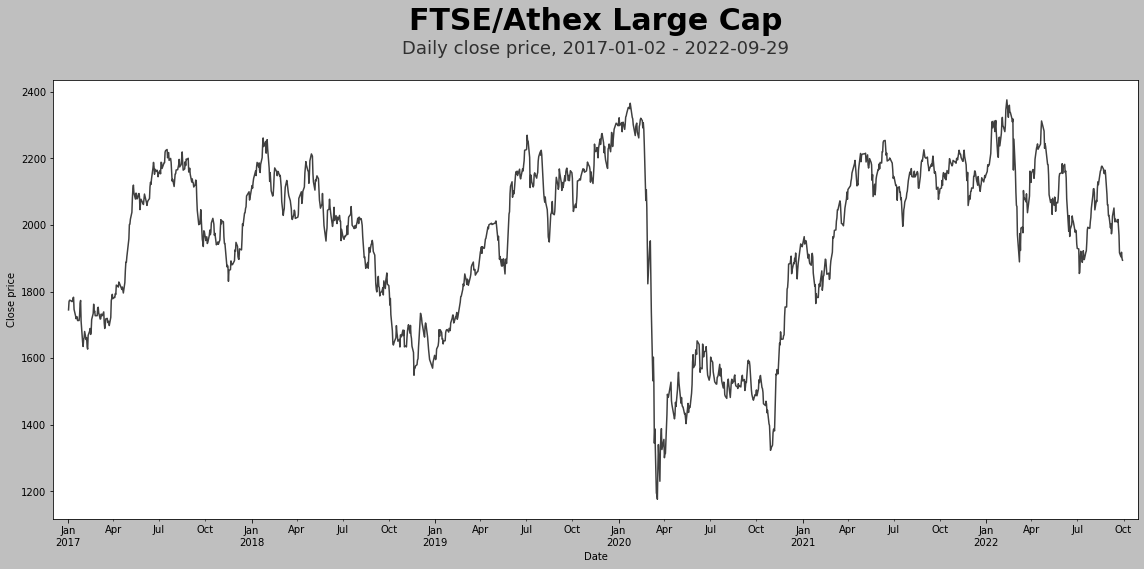

In [58]:
generatePlot(data['close'], 'Date', 'Close price', 'FTSE/Athex Large Cap', f"Daily close price, {datetime.date(data.index.min())} - {datetime.date(data.index.max())}")

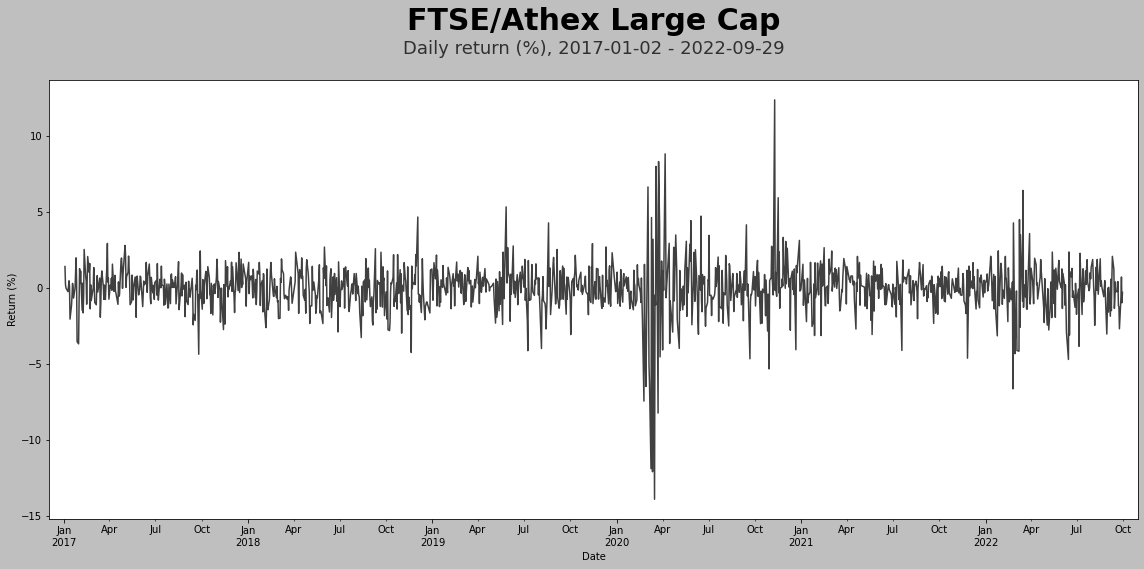

In [59]:
generatePlot(data['abs_return'], 'Date', 'Return (%)', 'FTSE/Athex Large Cap', f"Daily return (%), {datetime.date(data.index.min())} - {datetime.date(data.index.max())}")

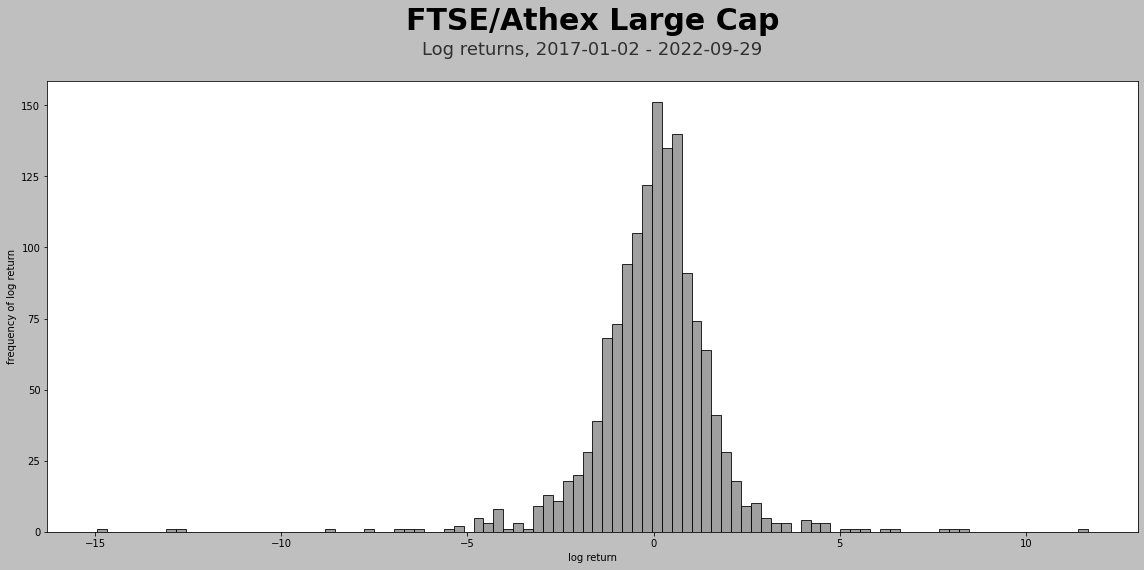

In [61]:
# histogram of log returns

matplotlib.style.use('grayscale')

fig, ax = plt.subplots(figsize=(16,8))

sns.histplot(
    alpha=0.75,
    data=data['log_return'],
    bins=100,
    ax=ax
)

ax.set_xlabel('log return')
ax.set_ylabel('frequency of log return')

ax.set_yticks(np.arange(0, 175, 25))

ax.text(x=0.5, y=1.1, s='FTSE/Athex Large Cap', fontsize=30, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=f"Log returns, {datetime.date(data.index.min())} - {datetime.date(data.index.max())}", fontsize=18, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout()
plt.show()

## Prophet